# Notebooks To Check Out For Beginners.
This notebook has several lines lines of code from [https://www.kaggle.com/ryanholbrook/create-your-first-submission](http://).
That notebook was really helpful for beginners like me who might have gotten a bit overwhelmed with all of this.   
Please go check out that notebook before attempting this competition as it is really helpful for beginners.

For Data Augmentation i referred to this notebook [https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96](http://).
It is an excellent notebook that explains how the data augmentation is exactly done. Refer to it if you want to gain some intution.

In [1]:
!pip install efficientnet --quiet
#Importing Stuff
import math, re, os
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Prepare To Load The Data

In [3]:
#This shows the path from which are data is loaded. Data for this competition is taken from Google Cloud Storage.

from kaggle_datasets import KaggleDatasets

GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(GCS_DS_PATH)

gs://kds-1cf8d5816507dc93db69e4b7f6fe354c5b7dcf8d7f737dccfb3f37c9


In [4]:
#Here we define which image sizes we are going to use. 
#We also load the training,validation and test filenames.
IMAGE_SIZE = [224, 224]
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-224x224'
AUTO = tf.data.experimental.AUTOTUNE

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

#Name of the different types of Flowers.
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', 
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                              

In [5]:
#This function rescales and reshapes the images so that they could be trained by a neural net
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) 
    return image

#This function creates image,label pairs for training. 
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "class": tf.io.FixedLenFeature([], tf.int64),  
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label

#This creates image,id pairs for unlabeled data. Useful for test set
def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string),  
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum 

#This function helps in loading the datasets. The data is not loaded in an orderly fashion as we are going to shuffle it anyways
#It can return both labeled and unlabaled data because of the two functions we specified above.
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

# Data Augmentation Using Custom Functions

In [6]:
#This function will be used to augment the data. Augmentation almost always helps in improving the performance of the model.
#It is always recommended to augment your data.
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transform matrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

def transform(image,label):
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

#Function to load the Training dataset
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(transform, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

#Function to load the Validation dataset
def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

#Function to load the Test dataset
def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

#Here we specify the number of images in each categories as they are fixed. You can also write a custom function using regex 
#to find the same
NUM_TRAINING_IMAGES = 12753
NUM_VALIDATION_IMAGES = 3712
NUM_TEST_IMAGES = 7382

# Load The Data

In [7]:
#Batch size is dependent on whether we are using TPU or not
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

#The functions mentioned above are called
ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

Training: <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
Validation: <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
Test: <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>


# Defining The Models

In [8]:
#Remember while using TPUs it is necessary to define your model in  the strategy.scope() block.
with strategy.scope():
    
    #EfficentNetB7
    pretrained_model1 = efficientnet.EfficientNetB7(
        weights='noisy-student',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3])
    
    pretrained_model1.trainable = True
    
    model1 = tf.keras.Sequential([
        pretrained_model1,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    #Xception
    pretrained_model2 = tf.keras.applications.Xception(
        weights='imagenet',
        include_top=False,
        input_shape=[*IMAGE_SIZE,3])
    
    pretrained_model2.trainable = True
    
    model2 = tf.keras.Sequential([
        pretrained_model2,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    #InceptionResNetV2
    pretrained_model3 = tf.keras.applications.InceptionResNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=[*IMAGE_SIZE,3])
        
    pretrained_model3.trainable = True
    
    model3 = tf.keras.Sequential([
        pretrained_model3,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    #DenseNet201
    pretrained_model4 = tf.keras.applications.DenseNet201(
        weights='imagenet',
        include_top=False,
        input_shape=[*IMAGE_SIZE,3])
        
    pretrained_model4.trainable = True
    
    model4 = tf.keras.Sequential([
        pretrained_model4,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    

74842112/74836368 [==============================] - 1s 0us/step


In [9]:
#Here we compile all of our models

model1.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)
model2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)
model3.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)
model4.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

In [10]:
#A custom learning rate function is defined. If the learning rate was too high in the start our pre trained weights would become useless
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) / rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr)
        return lr
    return lr(epoch,start_lr,min_lr,max_lr,rampup_epochs,sustain_epochs,exp_decay)

#It is used by the callbacks class. verbose is set to true to see the current learning rate at the start of the epoch
lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

# Training All The Models

In [11]:
#Here we finally put together everything we have done and start training our models
EPOCHS = 15
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history1 = model1.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/15
49/49 [==============================] - 65s 1s/step - sparse_categorical_accuracy: 0.3671 - loss: 2.7971 - val_sparse_categorical_accuracy: 0.4790 - val_loss: 2.4305 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008100000379979611.
Epoch 2/15
49/49 [==============================] - 23s 467ms/step - sparse_categorical_accuracy: 0.7133 - loss: 1.0756 - val_sparse_categorical_accuracy: 0.6934 - val_loss: 1.3000 - lr: 8.1000e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005060000335611404.
Epoch 3/15
49/49 [==============================] - 23s 467ms/step - sparse_categorical_accuracy: 0.8332 - loss: 0.6177 - val_sparse_categorical_accuracy: 0.8044 - val_loss: 0.8341 - lr: 5.0600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00023240000449121004.
Epoch 4/15
49/49 [==============================] - 23s 466ms/step - spa

In [12]:
history2 = model2.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/15
49/49 [==============================] - 29s 583ms/step - sparse_categorical_accuracy: 0.6088 - loss: 1.7113 - val_sparse_categorical_accuracy: 0.6441 - val_loss: 1.4583 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008100000379979611.
Epoch 2/15
49/49 [==============================] - 7s 153ms/step - sparse_categorical_accuracy: 0.8746 - loss: 0.4724 - val_sparse_categorical_accuracy: 0.7419 - val_loss: 1.0103 - lr: 8.1000e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005060000335611404.
Epoch 3/15
49/49 [==============================] - 8s 157ms/step - sparse_categorical_accuracy: 0.9417 - loss: 0.2169 - val_sparse_categorical_accuracy: 0.8362 - val_loss: 0.6187 - lr: 5.0600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00023240000449121004.
Epoch 4/15
49/49 [==============================] - 8s 161ms/step - spa

In [13]:
history3 = model3.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/15
49/49 [==============================] - 62s 1s/step - sparse_categorical_accuracy: 0.6432 - loss: 1.5096 - val_sparse_categorical_accuracy: 0.0614 - val_loss: 692.5338 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008100000379979611.
Epoch 2/15
49/49 [==============================] - 15s 302ms/step - sparse_categorical_accuracy: 0.8587 - loss: 0.5211 - val_sparse_categorical_accuracy: 0.2530 - val_loss: 30.0738 - lr: 8.1000e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005060000335611404.
Epoch 3/15
49/49 [==============================] - 15s 296ms/step - sparse_categorical_accuracy: 0.9260 - loss: 0.2726 - val_sparse_categorical_accuracy: 0.8252 - val_loss: 0.7277 - lr: 5.0600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00023240000449121004.
Epoch 4/15
49/49 [==============================] - 15s 298ms/step - 

In [14]:
history4 = model4.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/15
49/49 [==============================] - 57s 1s/step - sparse_categorical_accuracy: 0.6522 - loss: 1.4688 - val_sparse_categorical_accuracy: 0.1285 - val_loss: 4.2655 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008100000379979611.
Epoch 2/15
49/49 [==============================] - 15s 302ms/step - sparse_categorical_accuracy: 0.8630 - loss: 0.5249 - val_sparse_categorical_accuracy: 0.4278 - val_loss: 2.3397 - lr: 8.1000e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005060000335611404.
Epoch 3/15
49/49 [==============================] - 15s 300ms/step - sparse_categorical_accuracy: 0.9338 - loss: 0.2499 - val_sparse_categorical_accuracy: 0.8448 - val_loss: 0.6149 - lr: 5.0600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00023240000449121004.
Epoch 4/15
49/49 [==============================] - 15s 298ms/step - spa

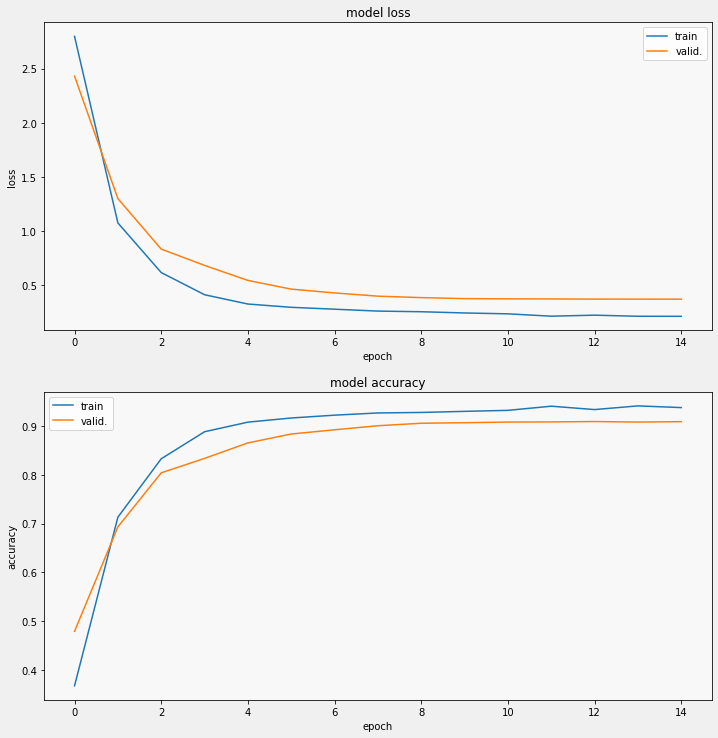

In [15]:
import matplotlib.pyplot as plt
#This function is used to display the traing curves and loss.
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1:
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])



#Here we display the loss and accuracy curves
#By changing the names we can view this data for any model
display_training_curves(
    history1.history['loss'],
    history1.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history1.history['sparse_categorical_accuracy'],
    history1.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [16]:
#Here we load the test dataset but this in order as it is important to have the same order as the sample submission.
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities1 = model1.predict(test_images_ds)
probabilities2 = model2.predict(test_images_ds)
probabilities3 = model3.predict(test_images_ds)
probabilities4 = model4.predict(test_images_ds)
probabilities = probabilities1+probabilities2+probabilities3+probabilities4
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Computing predictions...
[ 67  28  83 ... 103 102  62]


In [17]:
print('Generating submission.csv file...')

# Get image ids from test set and convert to unicode
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

# Look at the first few predictions
!head submission.csv

Generating submission.csv file...
id,label
252d840db,67
1c4736dea,28
c37a6f3e9,83
00e4f514e,103
59d1b6146,46
8d808a07b,53
aeb67eefb,52
53cfc6586,48
aaa580243,82
